In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
%load_ext autoreload
%autoreload 2

import seaborn as sns
from matplotlib import rcParams

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import connectivity graph and permutation related functions.

In [9]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import nhood_enrichment 

###  Useful plotting functions

In [10]:
import spatial_tools

In [11]:
def plot_zscores(df, title='title', shape=[1, 2],
                 loc1=[0, 0], loc2=[0, 1]):
    hm = df.pivot('leiden.i', 'leiden.j', 'z.score')
    annot = df.pivot('leiden.i', 'leiden.j', 'n.obs')

    plt.subplot2grid(shape, loc1, rowspan=1, colspan=1)
    plt.hist(np.array(hm).flatten(), bins=100);
    plt.xlabel('z-score')
    plt.ylabel('density')

    vmax = max(hm.max())
    vmin = -5 # vmax
    # print(vmin, vmax)
    idx = hm.index.astype(int).sort_values().astype(int)
    # print(idx)

    plt.subplot2grid(shape, loc2, rowspan=1, colspan=1)
    
    hm_plot = hm.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose()
    annot = annot.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose()
    sns.heatmap(hm_plot,
                annot=annot,
                fmt='.0f',
                cmap='Reds', vmin=0, vmax=vmax,
                cbar_kws={'label': 'Z-score'},
                annot_kws={'fontsize': 5}, xticklabels=True, yticklabels=True)
    plt.title('Co-enrichment of pairs in connectivity graph (%s)' % (title))
    plt.tight_layout()
    
def plot_nodes_heatmap(results, vmax=None):
    hm = results.pivot('leiden.i', 'leiden.j', 'z.score')
    vmax = vmax if vmax is None else max(hm.max())
    annot = results.pivot('leiden.i', 'leiden.j', 'n.obs')
    g = sns.clustermap(hm.fillna(0),
                       cmap='Reds', vmin=0, vmax=vmax, cbar_kws={'label': 'Z-score'})
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.subplots_adjust(right=.5, bottom=.7)
    
def plot_permtest_complex(res):
    rcParams['figure.figsize'] = [5, 5]
    rcParams['figure.dpi'] = 100
    pi = 0
    colors_top = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628"]
    
    ymin = int(min(res['z.score']) - 5)
    ymax = int(max(res['z.score']) + 5)
    max_by_k = res.sort_values('z.score', ascending=False).drop_duplicates('k').set_index('k')['z.score'].to_dict()
    color_by_k = res.sort_values('z.score', ascending=False).drop_duplicates('k').head(len(colors_top)).set_index('k')
    color_by_k['color'] = colors_top
    color_by_k = color_by_k['color'].to_dict()
    for k, grp2 in res.groupby(['k']):
        n_perm = list(set(grp2['n.perm']))[0]
        # print(k, sel.shape)
        plt.plot(grp2['n.rings'], grp2['z.score'], c=color_by_k[k] if k in color_by_k else 'gray',
                label=k if k in color_by_k else '',
                lw=2.0 if k in color_by_k else .1);
        plt.xlabel('connectivity degree')
        plt.ylabel('Z-score');
    plt.legend(fontsize=8);
    plt.ylim([ymin, ymax])
    pi += 1
        
def show_top6(adata, res):
    rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 8))
    ax = ax.flatten()
    sel = res.sort_values('z.score', ascending=False).drop_duplicates('k').head(6)
    ki = 0
    for ri, r in sel.iterrows():
        obs = r['n.obs']
        nrings = r['n.rings']
        z = r['z.score']
        k = r['k']
        title = '%s, rings=%i\nobs=%i\nZ=%.1f' % (k, nrings, obs, z)
        sc.pl.spatial(adata, color ="leiden", groups=set(k.split(':')),
                      ax = ax[ki], show = False, title = title, size=1.5)
        ki += 1
    plt.tight_layout()


In [12]:
def get_adata():
    # path to "raw" dataset folder
    BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
    dataset_name = "V1_Adult_Mouse_Brain"
    dataset_folder = os.path.join(
        BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
    )
    adata = sc.read_visium(
        dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
    )
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)    
    return adata

### Pre-processing to ensure data be ready for permutations functions

In [13]:
adata = get_adata()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Big test (10x visium data)

In [14]:
from spatial_tools.graph.build import spatial_connectivity
# from spatial_tools.graph.nhood import _count_observations_by_pairs
from spatial_tools.graph.nhood import *

In [15]:
spatial_connectivity(adata, n_rings=3)
conn = adata.obsp['spatial_connectivities']

sc.pp.neighbors(adata)
sc.tl.leiden(adata)

leiden = adata.obs['leiden']
N = adata.shape[0]
positions = np.arange(N) # .reshape(w, h)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [16]:
n_permutations = 100

In [17]:
nhood_enrichment(adata, cluster_key='leiden', n_perms=n_permutations)
nodes = adata.uns['leiden_nhood_enrichment']

In [18]:
res = pd.DataFrame(nodes['count']).reset_index().melt(id_vars='index')
z = pd.DataFrame(nodes['zscore']).reset_index().melt(id_vars='index')
res = pd.concat([res, z[z.columns[-1:]]], axis=1)
res.columns = ['leiden.i', 'leiden.j', 'n.obs', 'z.score']

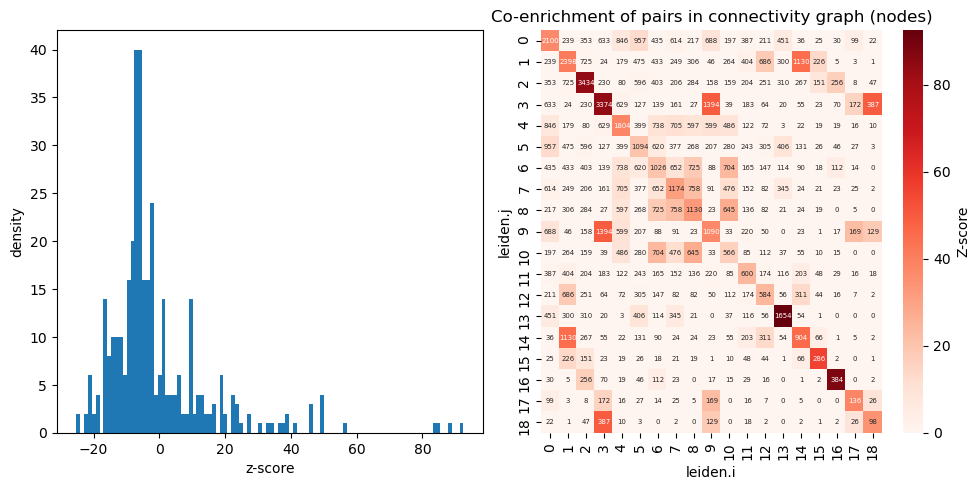

In [19]:
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [10, 5]
plot_zscores(res, title='nodes')

### Check based on nodes clusters that seemed of interest

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


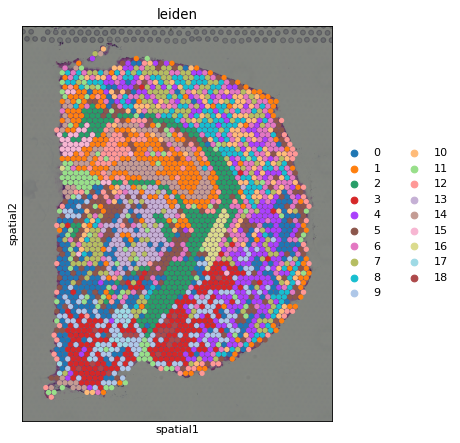

In [20]:
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = [5, 8]
sc.pl.spatial(adata, color = "leiden", size=1.5)

... storing 'leiden.query' as categorical


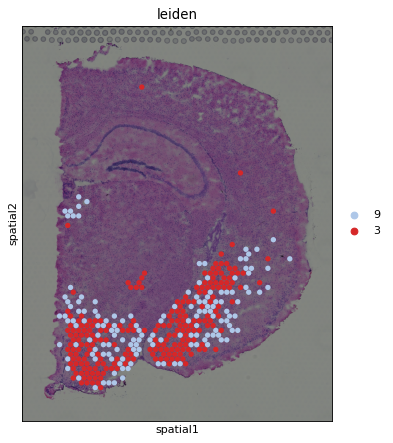

In [21]:
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = [5, 8]

settest = {'9', '3'}
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest, size=1.5);

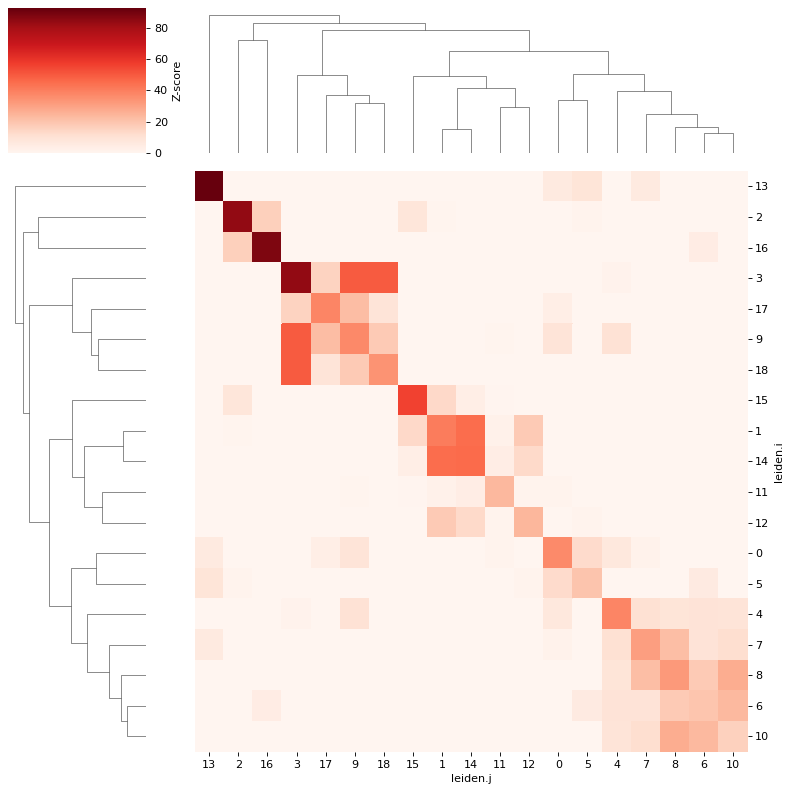

In [22]:
plot_nodes_heatmap(res)
plt.tight_layout()

### Permtest Z-scores for increasing connectivity values (~2 min based on parameters with 200 permutations each)

In [23]:

res = []
for n_rings in range(1, 5):
    spatial_connectivity(adata, n_rings=n_rings)
    conn = adata.obsp['spatial_connectivities']

    
    nhood_enrichment(adata, cluster_key='leiden', n_perms=n_permutations)
    nodes = adata.uns['leiden_nhood_enrichment']

    df = pd.DataFrame(nodes['count']).reset_index().melt(id_vars='index')
    z = pd.DataFrame(nodes['zscore']).reset_index().melt(id_vars='index')
    

    df = pd.concat([df, z[z.columns[-1:]]], axis=1)
    df.columns = ['leiden.i', 'leiden.j', 'n.obs', 'z.score']
    
    df['k'] = (np.where(df['leiden.i'].astype(int) > df['leiden.j'].astype(int), df['leiden.i'].astype(str), df['leiden.j'].astype(str)) + ":" + 
               np.where(df['leiden.j'].astype(int) > df['leiden.i'].astype(int), df['leiden.i'].astype(str), df['leiden.j'].astype(str)))
    df = df.drop_duplicates('k')
    
    df['n.rings'] = n_rings
    res.append(df)
res = pd.concat(res)

In [24]:
res['n.perm'] = n_permutations
res['k'] = res['leiden.i'].astype(str) + ":" + res['leiden.j'].astype(str)


In [25]:
res[res['leiden.i'].astype(int) != res['leiden.j'].astype(int)].sort_values('k')

,leiden.i,leiden.j,n.obs,z.score,k,n.rings,n.perm
10,10,0,197,-10.579118,10:0,3,100
10,10,0,95,-7.736478,10:0,2,100
10,10,0,336,-11.495541,10:0,4,100
10,10,0,36,-3.533920,10:0,1,100
29,10,1,264,-5.679217,10:1,3,100
...,...,...,...,...,...,...,...
142,9,7,39,-10.606581,9:7,2,100
161,9,8,0,-8.570294,9:8,1,100
161,9,8,53,-18.061576,9:8,4,100
161,9,8,8,-10.574702,9:8,2,100


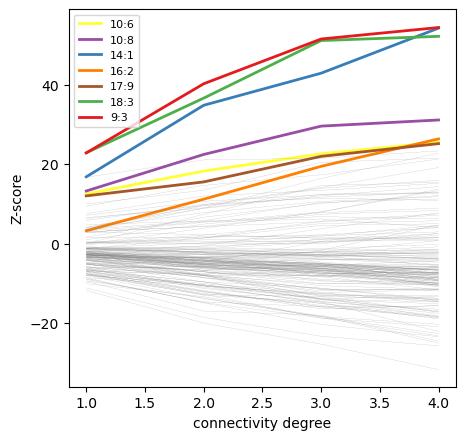

In [26]:
plot_permtest_complex(res[res['leiden.i'].astype(int) != res['leiden.j'].astype(int)])

In [27]:
res[res['leiden.i'].astype(int) != res['leiden.j']].sort_values('z.score', ascending=False).head()

,leiden.i,leiden.j,n.obs,z.score,k,n.rings,n.perm
66,9,3,2296,54.397936,9:3,4,100
33,14,1,1832,54.243708,14:1,4,100
75,18,3,589,52.174494,18:3,4,100
66,9,3,1394,51.505017,9:3,3,100
75,18,3,387,51.119933,18:3,3,100


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden.query' as categorical


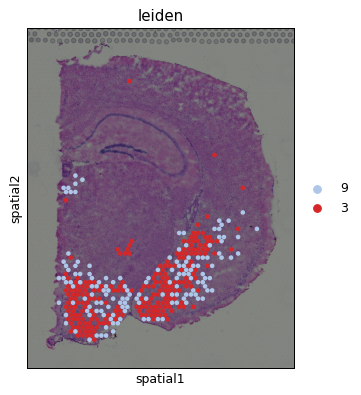

In [28]:
settest = {'3', '9'}
rcParams['figure.dpi'] = 90
rcParams['figure.figsize'] = [5, 5]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest, size=1.5)

### Show top 6 cases with different leiden ids

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


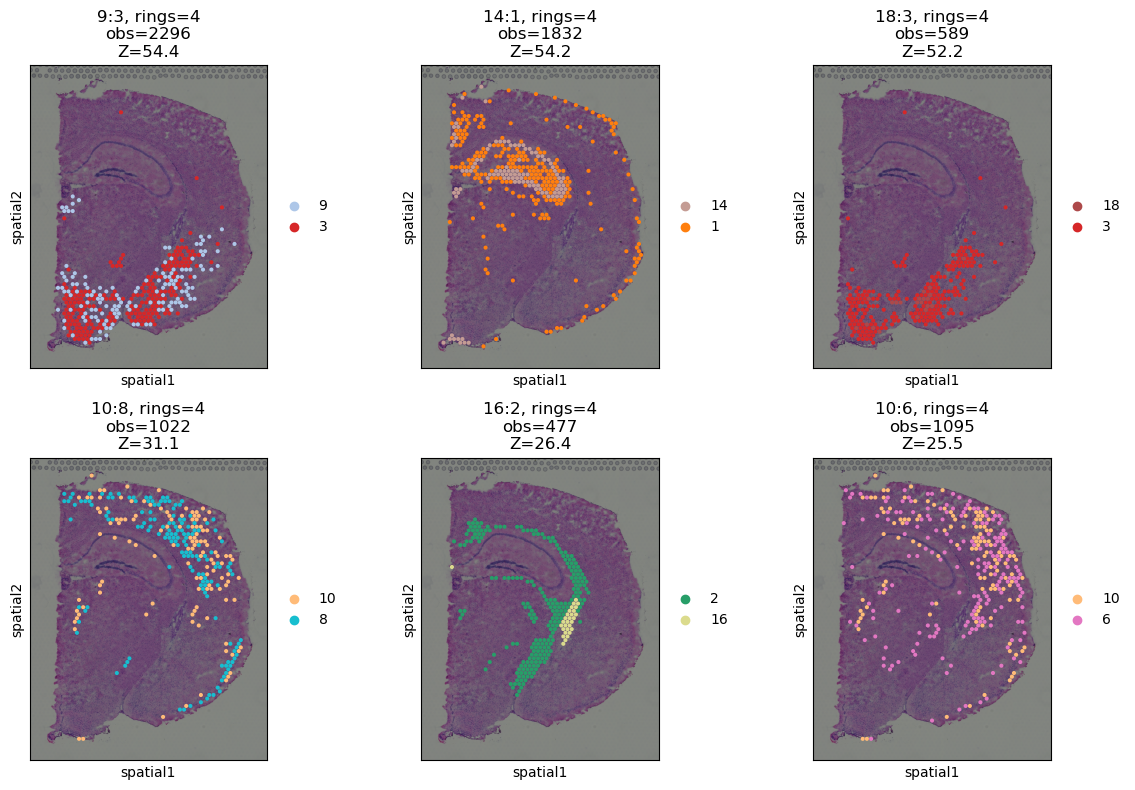

In [29]:
show_top6(adata, res[res['leiden.i'].astype(int) != res['leiden.j'].astype(int)])

### Show top 6 cases with same leiden ids

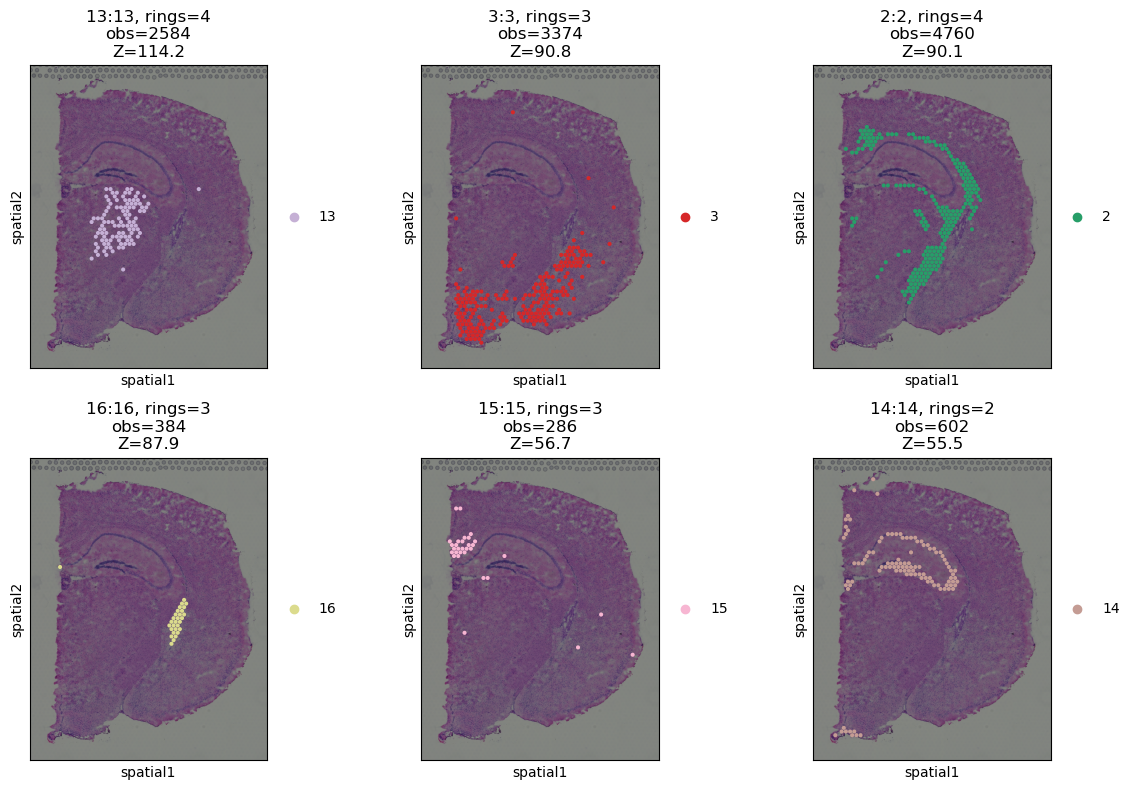

In [30]:
show_top6(adata, res)